# Libraries

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn import metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import data

In [30]:
%run Data_preprocessing.ipynb

************************************************************
There are 6 set of X
X_*_nozero
------------------------------------------------------------
Normalized version
X_*_norm
------------------------------------------------------------
There are 4 set of Y
y_train_t1, y_train_t2, y_valid_t1, y_valid_t2
when training, please use: 'y_train_t1_value,y_train_t2_value,y_valid_t1_value,y_valid_t2_value'
************************************************************


In [31]:
print(X_train_norm.shape)
print(X_valid_norm.shape)
print(X_test_norm.shape)

(16760, 61)
(2394, 61)
(4790, 61)


# Hyperparameters

In [10]:
input_size = X_train_norm.shape[1]
output_size = 1 #resulting LOS
learning_rate = 0.01
batch_size = 64
num_epochs = 200

# Create FullyNet

In [11]:
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 30)
        self.fc2 = nn.Linear(30, 15)
        self.fc3 = nn.Linear(15, 1)
        
        self.batchnorm1 = nn.BatchNorm1d(30)
        self.dropout = nn.Dropout(p=0.1)

        
        
    def forward(self, x):
         x = F.leaky_relu(self.fc1(x))
         x = self.batchnorm1(x)
         x = F.leaky_relu(self.fc2(x))
         x = self.dropout(x)
         x = F.leaky_relu(self.fc3(x))
         
         return x

# Data transform

In [12]:
class CusDatasetLoader(Dataset):
    def __init__(self,x,y):
        self.len = y.shape[0]
        self.x_data = x
        self.y_data = y
  
    def __len__(self):
        return self.len

    def __getitem__(self, index):
        #return self.dataframe.iloc[index]
        return self.x_data[index], self.y_data[index]

In [13]:
# X_shape(X) : used for split the data into a right tensor size
#input: X in shape of 16760 rows × 104 columns (df)
#output: X in shape of torch.Size([16760, 104, 1]) (tensor)

def X_tensor(X):
    X_tensor = torch.from_numpy(np.array(X)).to(torch.float32)
    #print(X_tensor.shape)
    #X_tensor = torch.stack(X_tensor).permute()
    print("X now in shape of",X_tensor.shape)
    return X_tensor

# y_tensor(y) : used for split the data into a right tensor size
#input: X in shape of 16760 rows × 7488 columns (df)
#output: X in shape of torch.Size([16760, 312, 24]) (tensor)

def y_tensor(y):
    y= torch.from_numpy(np.array(y)).to(torch.float32).reshape(len(y),1)
    print("y now in shape of",y.shape)
    return y

In [14]:
# X should be in smaples, 1, squence, rows
X1 = X_tensor(X_train_norm)
y1 = y_tensor(y_train_t2.iloc[:,-1].astype(float))

train_datasets = CusDatasetLoader(X1, y1)
train_loader = DataLoader(dataset=train_datasets, batch_size=batch_size, shuffle=True)

x,y = train_datasets[0]
print(x.shape)
print(y.shape)

X now in shape of torch.Size([16760, 61])
y now in shape of torch.Size([16760, 1])
torch.Size([61])
torch.Size([1])


# Model train

In [15]:
model = NN(input_size).to(device)

In [16]:
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer = optim.Adadelta(model.parameters(), lr = learning_rate)
criterion = torch.nn.MSELoss()

In [17]:
losses=[]
acc_list=[]

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        num_correct = 0
        num_samples = 0
        data = data.to(device=device)
        targets = targets.to(device=device)
        #print(targets)
        #targets = torch.squeeze(targets, 1).type(torch.LongTensor)
        
        # forward
        scores = model(data)
        #print(scores)
        loss = criterion(scores, targets)
        
        l2_lambda = 5e-05
        l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())
 
        loss = loss + l2_lambda * l2_norm
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        
        # gradient descent or adam step
        optimizer.step()
        
        #accuracy
        scores = model(data)
        predictions = scores
        predictions = predictions.detach().apply_( lambda x: 1 if x >= 0.5 else 0 )
        num_correct += int((predictions == targets).sum())
        num_samples += predictions.size(0)
        acc = num_correct / num_samples
        
    if epoch%5 == 0:
        losses.append(loss.detach().numpy() )
    print(f'Epoch {epoch:03}: | Loss: {loss:.5f} | Acc: {acc:.3f}')
        
        

Epoch 000: | Loss: 13.82047 | Acc: 0.000
Epoch 001: | Loss: 13.80637 | Acc: 0.000
Epoch 002: | Loss: 9.07845 | Acc: 0.000
Epoch 003: | Loss: 13.80927 | Acc: 0.000
Epoch 004: | Loss: 10.90219 | Acc: 0.000
Epoch 005: | Loss: 10.28979 | Acc: 0.000
Epoch 006: | Loss: 8.03953 | Acc: 0.000
Epoch 007: | Loss: 7.15203 | Acc: 0.000
Epoch 008: | Loss: 4.85668 | Acc: 0.000
Epoch 009: | Loss: 5.37139 | Acc: 0.000
Epoch 010: | Loss: 5.59398 | Acc: 0.000
Epoch 011: | Loss: 5.48301 | Acc: 0.000
Epoch 012: | Loss: 6.77532 | Acc: 0.000
Epoch 013: | Loss: 4.79550 | Acc: 0.000
Epoch 014: | Loss: 5.56914 | Acc: 0.000
Epoch 015: | Loss: 5.27937 | Acc: 0.000
Epoch 016: | Loss: 5.82924 | Acc: 0.000
Epoch 017: | Loss: 3.97211 | Acc: 0.000
Epoch 018: | Loss: 5.41533 | Acc: 0.000
Epoch 019: | Loss: 4.30222 | Acc: 0.000
Epoch 020: | Loss: 5.48135 | Acc: 0.000
Epoch 021: | Loss: 3.87269 | Acc: 0.000
Epoch 022: | Loss: 4.29934 | Acc: 0.000
Epoch 023: | Loss: 3.99976 | Acc: 0.000
Epoch 024: | Loss: 2.86365 | Acc: 0

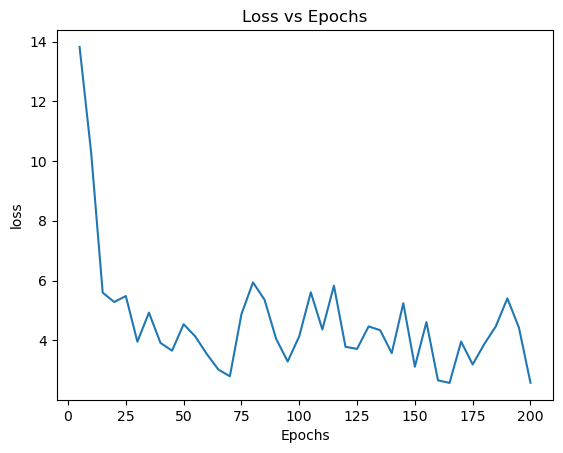

In [18]:
#plotting the loss
x_range = list(range(5,5*len(losses)+5,5))
plt.plot(x_range,losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

# Model RMSE

In [19]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval
    model.eval()

    with torch.no_grad():
        for x, y in train_loader:
            x = x.to(device=device)
            y.to(device=device)
            #y = torch.squeeze(y.to(device=device), 1)
            #print(y.shape)

            scores = model(x)
            predictions = scores
            predictions = predictions.apply_( lambda x: 1 if x >= 0.5 else 0 )
            num_correct += int((predictions == y).sum())
            num_samples += predictions.size(0)

    # Toggle model back to train
    model.train()
    return num_correct / num_samples

In [20]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:2f} %")
#print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f} %")

Accuracy on training set: 0.000000 %


In [21]:
X2 = X_tensor(X_valid_norm)
y2 = y_tensor(y_valid_t2.iloc[:,-1])

Valid_datasets = CusDatasetLoader(X2, y2)
Valid_loader = DataLoader(dataset=Valid_datasets, batch_size=batch_size, shuffle=True)
print(f"Accuracy on valid set: {check_accuracy(Valid_loader, model)*100:.2f} %")

X now in shape of torch.Size([2394, 61])
y now in shape of torch.Size([2394, 1])
Accuracy on valid set: 0.00 %


# Test

In [24]:
def test(loader, model):
    # Set model to eval
    model.eval()
    res = torch.tensor([], dtype=torch.int64)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y.to(device=device)

            scores = model(x)
            predictions = scores
            res =  torch.cat((predictions, res), 0)  
    model.train()
   
    return res

In [32]:
X_test_final = X_tensor(X_test_norm)
y_final = torch.zeros([4790,1])

test_datasets = CusDatasetLoader(X_test_final, y_final)
test_loader = DataLoader(dataset=test_datasets, batch_size=batch_size, shuffle=True)

result = test(test_loader, model)
result

X now in shape of torch.Size([4790, 61])


tensor([[2.4100],
        [3.0967],
        [2.8022],
        ...,
        [3.5233],
        [2.9107],
        [3.4190]])

In [33]:

#df.index = ['Row_1', 'Row_2', 'Row_3', 'Row_4']
res1 = pd.DataFrame(result.tolist(), columns=["Predicted"])
res1.index = X_test.index
res1.index.name = 'Id'
pd.DataFrame(res1).to_csv('outfullynet.csv')
#print(torch.count_nonzero(torch.from_numpy(np.array(res1)).to(torch.float32)))
res1

,Predicted
Id,
32_175413_295037,2.409992
33_176176_296681,3.096665
42_119203_210828,2.802215
44_181750_291554,3.928783
61_176332_252348,1.861334
...,...
99883_150755_276467,3.075818
99897_162913_266801,4.244951
99913_175989_292375,3.523263
